In [59]:
import game_runner
import simple_agent
import llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import make_prompt


In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [62]:
rounds = []
p1_values = []
p2_values = []
max_rounds = 5
p1_offers = []
p2_offers = []
game = game_runner.NegotitaionGame(
    player1_agent=llm_agent.LLMAgent(),
    player2_agent=llm_agent.LLMAgent(),
    num_items=10,
    item_value_range=[0, 101],
    gamma=0.9,
    max_rounds=max_rounds,
    outside_offer_value_range=[1, 1000]
)

rounds = []
p1_values = []
p2_values = []

#LOOP TO RUN NEGOTIATION
while game.in_progress:  
    current_step = len(game.history[0]) + len(game.history[1]) + 1
    current_round = (current_step - 1) // 2 + 1 
    current_player = 1 if current_step % 2 == 1 else 2
    
    print(f"\n{'='*80}")
    print(f"Round {current_round}, Player {current_player}'s turn (Step {current_step})")
    print(f"{'='*80}")

    prev_offer = game.current_offer  
    game.step()  
    
    if game.current_offer: #NORMAL ROUNDS
        p1_kept = game.items - np.array(game.current_offer.offer)
        p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
        p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        
        if current_player == 2: #PLAYER 2 OFFERS
            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            p1_offers.append(prev_offer.offer)  
            p2_offers.append(game.current_offer.offer)
            print(f"\nRound {current_round} Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")
    
    
    if current_round == game.max_rounds and current_player == 2: #IF WE ARE ON THE LAST ROUND
        if game.current_offer and game.current_offer != prev_offer: #IF PLAYER 2 MAKES A COUNTEROFFER WE TREAT IT AS WALK
            print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        elif game.current_offer == prev_offer: #IF PLAYER 2 ACCEPTS
            print("\nPlayer 2's final action: ACCEPT")
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        else: #IF PLAYER 2 WALKS
            print("\nPlayer 2's final action: WALK")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        
        game.in_progress = False
        print(f"\nRound {current_round} Final Values:")
        print(f"Player 1: {p1_value:.2f}")
        print(f"Player 2: {p2_value:.2f}")
        
        rounds.append(current_round)
        p1_values.append(p1_value)
        p2_values.append(p2_value)
        break

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")


Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 10 types of items, called item 1 through item 10.
    There are 8 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5, 3 units of item 6, 2 units of item 7, 6 units of item 8, 3 units of item 9, 3 units of item 10 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 43 for item 1, 21 for item 2, 26 for item 3, 22 for item 4, 61 for item 5, 52 for item 6, 62 for item 7, 81 for item 8, 0 for item 9, 94 for item 10.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 518.

    The negotiation proceeds i

## Discounted Values Over Time

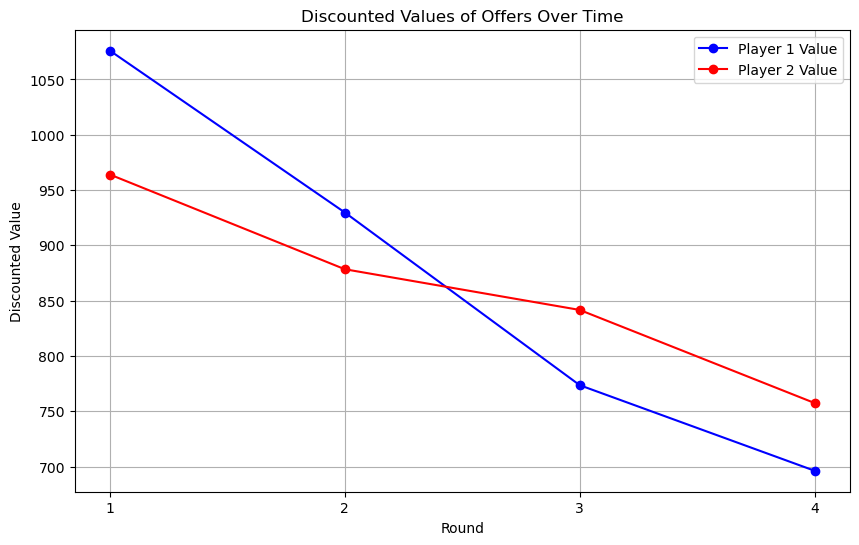


Final Values:
Player 1: 696.20
Player 2: 757.43


In [63]:
plt.figure(figsize=(10, 6))
plt.plot(rounds, p1_values, 'b-o', label='Player 1 Value')
plt.plot(rounds, p2_values, 'r-o', label='Player 2 Value')
plt.xlabel('Round')
plt.xticks(range(1, max(rounds)+1))
plt.ylabel('Discounted Value')
plt.title('Discounted Values of Offers Over Time')
plt.legend()
plt.grid(True)
plt.show()

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")

## Offer Evolution

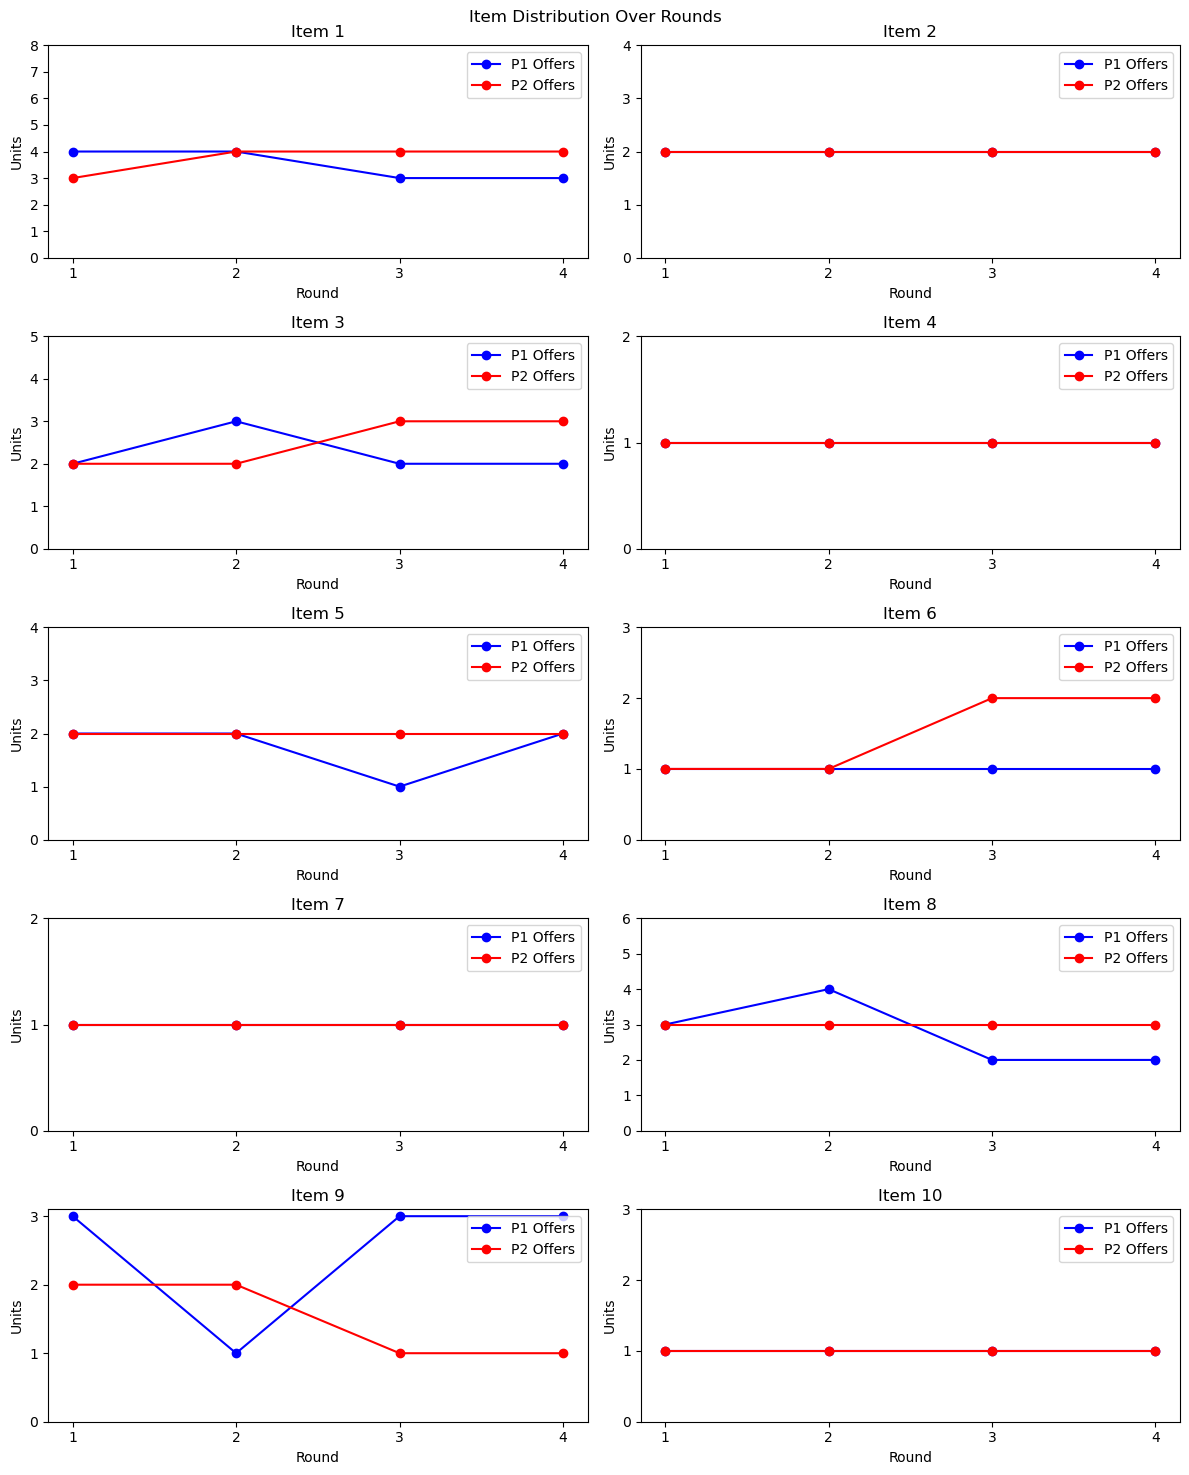

In [64]:
num_rows = (game.num_items + 1) // 2 
fig, axs = plt.subplots(num_rows, 2, figsize=(12, 3*num_rows))
fig.suptitle('Item Distribution Over Rounds')


valid_rounds = rounds[:len(p1_offers)]  
for i in range(game.num_items):
    row = i // 2
    col = i % 2
    axs[row, col].plot(valid_rounds, [h[i] for h in p1_offers], 'b-o', label='P1 Offers')
    axs[row, col].plot(valid_rounds, [h[i] for h in p2_offers], 'r-o', label='P2 Offers')
    axs[row, col].set_title(f'Item {i+1}')
    axs[row, col].set_xlabel('Round')
    axs[row, col].set_ylabel('Units')
    axs[row, col].set_xticks(range(1, max(valid_rounds) + 1))
    axs[row, col].set_yticks(range(0, game.items[i] + 1))
    axs[row, col].legend()


if game.num_items % 2 == 1:  
    axs[-1, -1].remove()  

plt.tight_layout() 

## Negotiation Gap

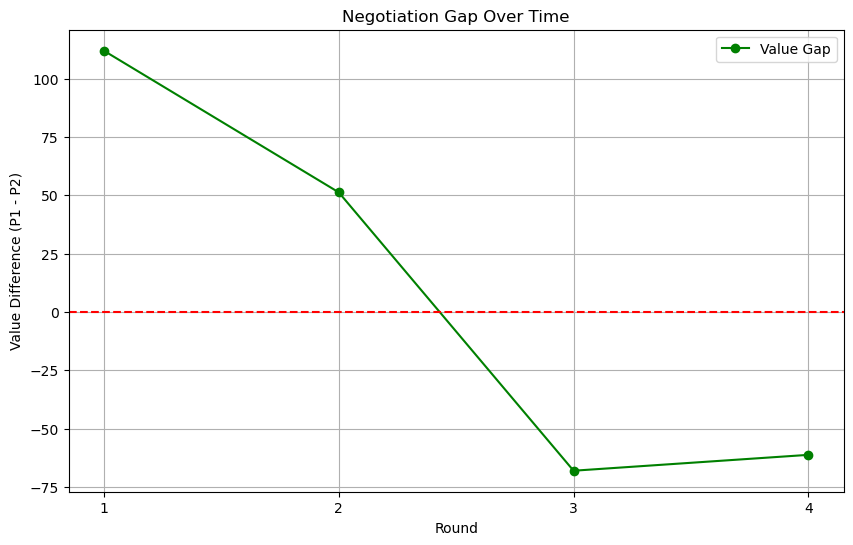

In [65]:
plt.figure(figsize=(10, 6))
value_gaps = [p1 - p2 for p1, p2 in zip(p1_values, p2_values)]
plt.plot(rounds, value_gaps, 'g-o', label='Value Gap')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Round')
plt.ylabel('Value Difference (P1 - P2)')
plt.title('Negotiation Gap Over Time')
plt.xticks(range(1, max(rounds)+1))  
plt.legend()
plt.grid(True)
plt.show()

## Basic Fairness



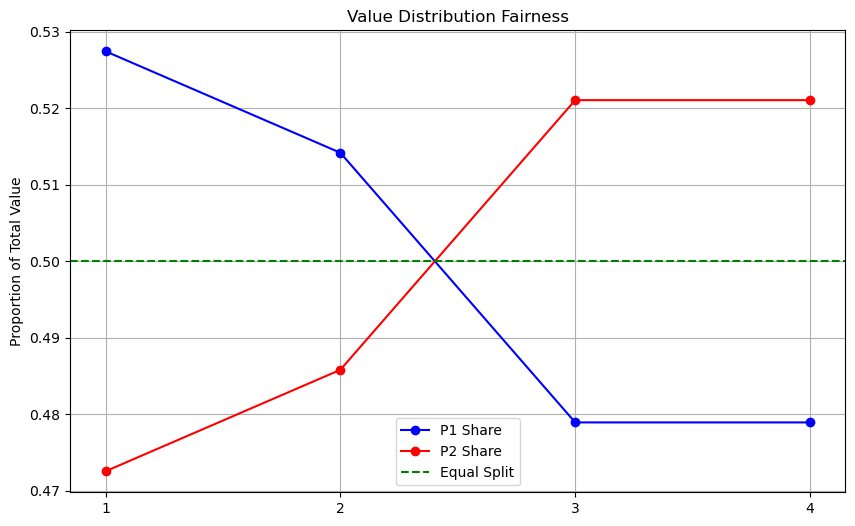

In [66]:
plt.figure(figsize=(10, 6))
fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]
plt.plot(rounds, [f[0] for f in fairness], 'b-o', label='P1 Share')
plt.plot(rounds, [f[1] for f in fairness], 'r-o', label='P2 Share')
plt.axhline(y=0.5, color='g', linestyle='--', label='Equal Split')
plt.ylabel('Proportion of Total Value')
plt.xticks(range(1, max(rounds)+1)) 

plt.title('Value Distribution Fairness')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
evaluator = game_runner.GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print("\nBasic Metrics:")
print(f"Final P1 Value: {p1_values[-1]:.2f}")
print(f"Final P2 Value: {p2_values[-1]:.2f}")
print(f"Final Value Gap: {value_gaps[-1]:.2f}")
print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")


Negotiation Evaluation:
Outside Offer Rational: Yes

Basic Metrics:
Final P1 Value: 696.20
Final P2 Value: 757.43
Final Value Gap: -61.24
Final Fairness Ratio: 0.48 : 0.52
